In [1]:
import random
import seaborn as sns
import torch
import numpy as np
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import Normal
import time 

In [2]:
# define the model for the Gaussian distribution
class GaussianDistributionModel(nn.Module):
    def __init__(self, mu_init: float, sigma_init: float):
        super(GaussianDistributionModel, self).__init__()
        self.mu = nn.Parameter(torch.tensor([mu_init]), requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor([sigma_init]), requires_grad=True)

    def forward(self, x):
        return - torch.log((1 / (self.sigma * torch.sqrt(torch.tensor(2 * torch.pi))) * \
               torch.exp(-0.5 * ((x - self.mu) / self.sigma) ** 2)))

    def sample(self, num_samples: int):
        return self.mu + self.sigma * torch.randn(num_samples)

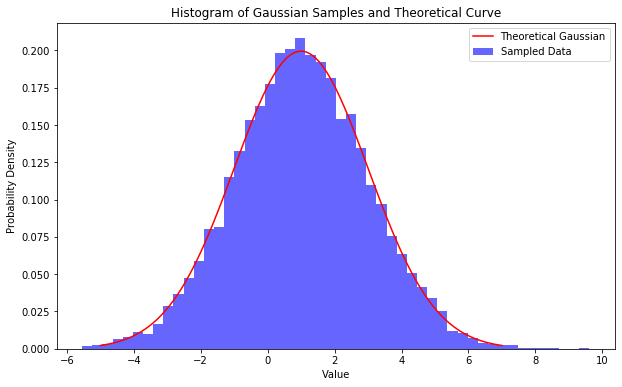

In [3]:
mu_init = 1.0
sigma_init = 2.0
model = GaussianDistributionModel(mu_init, sigma_init)

# generate some samples from the Gaussian distribution
num_samples = 10000
samples = model.sample(num_samples).detach().numpy()

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, alpha=0.6, color='b', density=True, label='Sampled Data')

x = np.linspace(mu_init - 3*sigma_init, mu_init + 3*sigma_init, 100)
pdf = 1 / (sigma_init * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu_init) / sigma_init) ** 2)
plt.plot(x, pdf, 'r-', label='Theoretical Gaussian')

# check plot

plt.title('Histogram of Gaussian Samples and Theoretical Curve')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [4]:
# define loss function converge to the energy discrepancy 
def ED(E_theta, samples, M = 4, t =1, w=1):
    device = samples.device

    si_i = np.sqrt(t) * torch.randn_like(samples).to(device)
    si_ij = np.sqrt(t) * torch.randn(samples.size(0), M, *samples.shape[1:]).to(device)

    sum_part = samples.unsqueeze(1) + si_i.unsqueeze(1) + si_ij
    
    # compute the part of loss part
    E_1 = E_theta(samples.unsqueeze(1)).view(samples.size(0), -1)
    E_2 = E_theta(sum_part.view(-1, *samples.shape[1:])).view(samples.size(0), -1)

    # compute the loss in the sum part
    loss_i = E_1 - E_2
    
    if w != 0:
        loss_i = torch.cat([loss_i, np.log(w) * torch.ones_like(loss_i[:, :1])], dim=-1)
    
    # take the logsumexp step to compute the loss
    loss = loss_i.logsumexp(dim=-1).mean()

    return loss

In [5]:
# take all true values for the target distribution
true_mu = 2
true_sigma = 0.5
observed_data = np.random.normal(true_mu, true_sigma, 1000)
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

# define hyperparameters of the energy discrepancy
w_stable1 = 10.0
M1 = 4.0
t1 = 1.0

# train the loop
def train(model, data, epochs, learning_rate=0.01):
    loss1 = []
    mu1 = []
    sigma1 = []
    step = []
    l2 = []

    time1 = time.time()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, w=w_stable1)

        loss1.append(loss.item())
        mu1.append(model.mu.item())
        sigma1.append(model.sigma.item())

        sample_train = model.sample(data.size(0)).detach().numpy()
        MSE = ((sample_train - data.detach().numpy()) ** 2).mean()
        l2.append(MSE)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, mu = {model.mu.item()}, sigma = {model.sigma.item()}")
        step.append(epoch)

    time2 = time.time()
    time_cost = time2 - time1

    return loss1, mu1, sigma1, step, time_cost, l2


# initilaize the model
model = GaussianDistributionModel(mu_init=0.0, sigma_init=2.0)

# train the model
losses, mus_ED, sigmas_ED,step, computing_time, l2_log = train(model, observed_data_tensor, epochs=1000)


Epoch 0: Loss = 2.631040096282959, mu = 0.009999996982514858, sigma = 2.009999990463257
Epoch 100: Loss = 2.5955312252044678, mu = 0.8865650296211243, sigma = 1.833088755607605
Epoch 200: Loss = 2.500370979309082, mu = 2.0392394065856934, sigma = 0.6246042251586914
Epoch 300: Loss = 2.490159273147583, mu = 2.0137693881988525, sigma = 0.6053199172019958
Epoch 400: Loss = 2.4951932430267334, mu = 2.0066206455230713, sigma = 0.6047598123550415
Epoch 500: Loss = 2.488361358642578, mu = 2.0056700706481934, sigma = 0.6202738881111145
Epoch 600: Loss = 2.494748830795288, mu = 2.0140936374664307, sigma = 0.6203629970550537
Epoch 700: Loss = 2.4846713542938232, mu = 2.0163662433624268, sigma = 0.6155972480773926
Epoch 800: Loss = 2.4992401599884033, mu = 2.014366865158081, sigma = 0.6133327484130859
Epoch 900: Loss = 2.4995710849761963, mu = 2.010258197784424, sigma = 0.6089426279067993


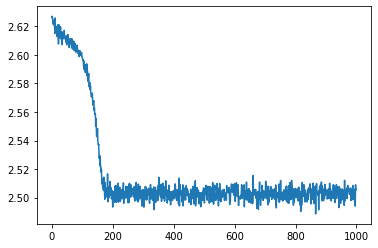

In [229]:
plt.plot(step,losses)
plt.savefig('Loss.png')

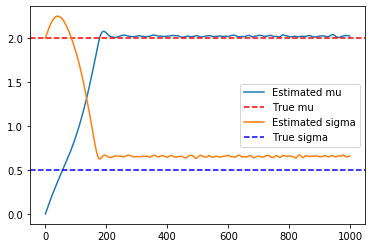

In [230]:
plt.plot(mus_ED, label='Estimated mu')
plt.axhline(y=true_mu, color='r', linestyle='--', label='True mu')
plt.plot(sigmas_ED, label='Estimated sigma')
plt.axhline(y=true_sigma, color='b', linestyle='--', label='True sigma')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('parameters_ED.png')

# comparison with CD

In [14]:
def target_distribution(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

#define gradient of normal distribution
def gradient(x,mu,sigma):
    pdf=np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*(np.sqrt(2*np.pi)))
    grad_pdf_sigma = -np.exp(-(x-mu)**2/(2*sigma**2))/(sigma**2*np.sqrt(2*np.pi))+(x-mu)**2*np.exp(-(x-mu)**2/(2*sigma**2))/(sigma**4*np.sqrt(2*np.pi))
    gradient_sigma = grad_pdf_sigma/pdf
    grad_pdf_mu = ((x-mu)/sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*(np.sqrt(2*np.pi)))
    gradient_mu= grad_pdf_mu/pdf
    return gradient_mu , gradient_sigma

def metropolis_hastings(proposal_std, initial_state, num_samples,mu,sigma):
    #initialize,set current state to initial state
    samples=[initial_state]
    current_state=initial_state
    for i in range(num_samples):
        #calculate candidate
        candidate=np.random.normal(current_state,proposal_std)
        #acceptance ration
        a_r=target_distribution(candidate,mu,sigma)/target_distribution(current_state,mu,sigma)
        if np.random.uniform(0,1)<a_r:
            current_state=candidate
        #X'
        samples.append(current_state)
    X_dash=samples[1:]
    return X_dash

In [15]:
def CD_1step(proposal_std, sample, iteration, mu0, sigma0, eta):
    ni=[]
    mui=[]
    sigmai=[]
    initial_state=sample[0]
    num_samples = len(sample)

    time1 = time.time()
    l2 = []

    for i in range(iteration):
        sum1_mu=0
        sum_dash_mu=0
        sum1_sigma=0
        sum_dash_sigma=0
        initial_state=sample[0]
        X = metropolis_hastings(proposal_std, initial_state, num_samples,mu0,sigma0)
        #calculate the sum of gradient
        for j in range(num_samples):
            #gradient of log(p(x))
            sum1_mu += gradient(sample[j],mu0,sigma0)[0]
            sum1_sigma += gradient(sample[j],mu0,sigma0)[1]
        for k in range(num_samples):
            sum_dash_mu += gradient(X[k],mu0,sigma0)[0]
            sum_dash_sigma += gradient(X[k],mu0,sigma0)[1]
        expected1_mu = sum1_mu/num_samples
        expected_dash_mu = sum_dash_mu/num_samples
        expected1_sigma = sum1_sigma/num_samples
        expected_dash_sigma = sum_dash_sigma/num_samples
        sigma_i = sigma0 + eta*(expected1_sigma-expected_dash_sigma)
        mu_i = mu0 + eta*(expected1_mu-expected_dash_mu)
        n=i+1
        ni.append(n)
        mui.append(mu_i)
        sigmai.append(sigma_i)
        mu0 = mu_i
        sigma0 = sigma_i
        
        MSE_1_step = ((X - sample) ** 2).mean()
        l2.append(MSE_1_step)

    time2 = time.time()
    time_1_step = time2-time1
    return mui,sigmai,ni,time_1_step,l2

In [16]:
def CD_persistent(proposal_std, sample, iteration, mu0, sigma0, eta):
    ni=[]
    mui=[]
    sigmai=[]
    initial_state=sample[0]
    num_samples = len(sample)
    l2 = []

    time1 = time.time()

    for i in range(iteration):
        sum1_mu=0
        sum_dash_mu=0
        sum1_sigma=0
        sum_dash_sigma=0
        initial_state=sample[0]

        X = metropolis_hastings(proposal_std, initial_state, num_samples,mu0,sigma0)
        initial_state = X[-1]
        
        #calculate the sum of gradient
        for j in range(num_samples):
            #gradient of log(p(x))
            sum1_mu += gradient(sample[j],mu0,sigma0)[0]
            sum1_sigma += gradient(sample[j],mu0,sigma0)[1]
        for k in range(num_samples):
            sum_dash_mu += gradient(X[k],mu0,sigma0)[0]
            sum_dash_sigma += gradient(X[k],mu0,sigma0)[1]
        expected1_mu = sum1_mu/num_samples
        expected_dash_mu = sum_dash_mu/num_samples
        expected1_sigma = sum1_sigma/num_samples
        expected_dash_sigma = sum_dash_sigma/num_samples
        sigma_i = sigma0 + eta*(expected1_sigma-expected_dash_sigma)
        mu_i = mu0 + eta*(expected1_mu-expected_dash_mu)
        n=i+1
        ni.append(n)
        mui.append(mu_i)
        sigmai.append(sigma_i)
        mu0 = mu_i
        sigma0 = sigma_i
        
        MSE_per = ((X - sample) ** 2).mean()
        l2.append(MSE_per)

    time2 = time.time()
    time_persistent = time2-time1
    return mui,sigmai,ni,time_persistent,l2

In [17]:
def CD_3step(proposal_std, sample, iteration, mu0, sigma0, eta):
    ni=[]
    mui=[]
    sigmai=[]
    initial_state=sample[0]
    num_samples = len(sample)

    time1 = time.time()
    l2 = []

    for i in range(iteration):
        sum1_mu=0
        sum_dash_mu=0
        sum1_sigma=0
        sum_dash_sigma=0
        initial_state=sample[0]

        X1 = metropolis_hastings(proposal_std, initial_state, num_samples,mu0,sigma0)
        X2 = metropolis_hastings(proposal_std, X1[-1], num_samples,mu0,sigma0)
        X = metropolis_hastings(proposal_std, X2[-1], num_samples,mu0,sigma0)
        
        #calculate the sum of gradient
        for j in range(num_samples):
            #gradient of log(p(x))
            sum1_mu += gradient(sample[j],mu0,sigma0)[0]
            sum1_sigma += gradient(sample[j],mu0,sigma0)[1]
        for k in range(num_samples):
            sum_dash_mu += gradient(X[k],mu0,sigma0)[0]
            sum_dash_sigma += gradient(X[k],mu0,sigma0)[1]
        expected1_mu = sum1_mu/num_samples
        expected_dash_mu = sum_dash_mu/num_samples
        expected1_sigma = sum1_sigma/num_samples
        expected_dash_sigma = sum_dash_sigma/num_samples
        sigma_i = sigma0 + eta*(expected1_sigma-expected_dash_sigma)
        mu_i = mu0 + eta*(expected1_mu-expected_dash_mu)
        n=i+1
        ni.append(n)
        mui.append(mu_i)
        sigmai.append(sigma_i)
        mu0 = mu_i
        sigma0 = sigma_i

        MSE_3_step = ((X - sample) ** 2).mean()
        l2.append(MSE_3_step)

    time2 = time.time()
    time_3_step = time2-time1
    return mui,sigmai,ni,time_3_step,l2

In [236]:
# 1-step CD
# get the mu and sigma iteratively and plot the convergence
eta=0.01

#keep the initial parameters equal
mu0=0
sigma0=2
proposal_std=1
num_samples= len(observed_data)
iterations = 1000

mui,sigmai,ni,time_1_step, l2_1_step= CD_1step(proposal_std, observed_data, iterations, mu0,sigma0,eta)

In [238]:
mui_pers,sigmai_pers,ni_pers,time_persistent, l2_persistent = CD_persistent(proposal_std, observed_data, iterations, mu0,sigma0,eta)

In [240]:
mui_3step,sigmai_3step,ni_3step,time_3_step, l2_3_step = CD_3step(proposal_std, observed_data, iterations, mu0,sigma0,eta)

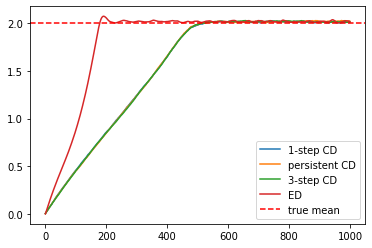

In [243]:
# comparison on mean covergence
plt.plot(mui, label='1-step CD')
plt.plot(mui_pers, label='persistent CD')
plt.plot(mui_3step, label='3-step CD')
plt.plot(mus_ED, label='ED')
plt.axhline(y=true_mu, color='r', linestyle='dashed', label='true mean')
plt.legend()
plt.savefig('mean_convergence_1Dcompare.png')

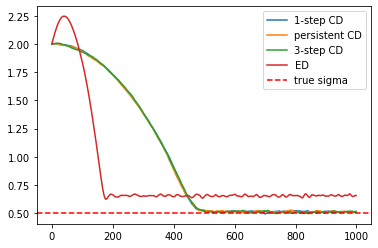

In [244]:
# comparison on sigma covergence
plt.plot(sigmai, label='1-step CD')
plt.plot(sigmai_pers, label='persistent CD')
plt.plot(sigmai_3step, label='3-step CD')
plt.plot(sigmas_ED, label='ED')
plt.axhline(y=true_sigma, color='r', linestyle='dashed', label='true sigma')
plt.legend()
plt.savefig('sigma_convergence_1Dcompare.png')

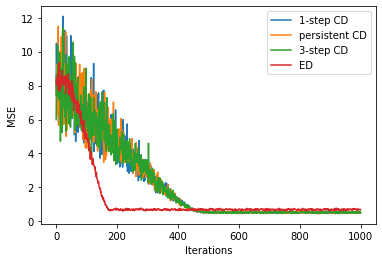

In [476]:
# comparison on L2 loss
plt.plot(l2_1_step, label='1-step CD')
plt.plot(l2_persistent, label='persistent CD')
plt.plot(l2_3_step, label='3-step CD')
plt.plot(l2_log, label='ED')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.savefig('L2_loss_1Dcompare.png')

In [25]:
# Final MSE and computational time

sample_train = model.sample(1000).detach().numpy()
MSE = ((sample_train - observed_data) ** 2).mean()
print(f"MSE: {MSE}")
print(f"Computing time: {computing_time}")

model = GaussianDistributionModel(mu_init= mui[-1], sigma_init= sigmai[-1])
sample_train_1step = model.sample(1000).detach().numpy()
MSE_1_step = ((sample_train_1step - observed_data) ** 2).mean()
print(f"1 step CD MSE: {MSE_1_step}")
print(f"1 step CD Computing time: {time_1_step}")

model = GaussianDistributionModel(mu_init= mui_pers[-1], sigma_init= sigmai_pers[-1])
sample_train_persistent = model.sample(1000).detach().numpy()
MSE_persistent = ((sample_train_persistent - observed_data) ** 2).mean()
print(f"persistent CD MSE: {MSE_persistent}")
print(f"persistent CD Computing time: {time_persistent}")

model = GaussianDistributionModel(mu_init= mui_3step[-1], sigma_init= sigmai_3step[-1])
sample_train_3step = model.sample(1000).detach().numpy()
MSE_3_step = ((sample_train_3step - observed_data) ** 2).mean()
print(f"3 step CD MSE: {MSE_3_step}")
print(f"3 step CD Computing time: {time_3_step}")

MSE: 0.7674220056487475
Computing time: 1.572596788406372
1 step CD MSE: 0.4976678166999234
1 step CD Computing time: 70.38572788238525
persistent CD MSE: 0.5531203794688335
persistent CD Computing time: 77.24979710578918
3 step CD MSE: 0.5135141692313712
3 step CD Computing time: 107.85198020935059


# Truncated 1D normal

In [6]:
# train the loop
def train(model, data, epochs, learning_rate=0.01):
    loss1 = []
    mu1 = []
    sigma1 = []
    step = []
    l2 = []

    time1 = time.time()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, w=w_stable1)

        loss1.append(loss.item())
        mu1.append(model.mu.item())
        sigma1.append(model.sigma.item())

        sample_train = model.sample(data.size(0)).detach().numpy()
        MSE_1_step = ((sample_train - observed_data.detach().numpy()) ** 2).mean()
        l2.append(MSE_1_step)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, mu = {model.mu.item()}, sigma = {model.sigma.item()}")
        step.append(epoch)

    time2 = time.time()
    time_cost = time2 - time1

    return loss1, mu1, sigma1, step, time_cost, l2


In [7]:
# take all true values for the same target distribution with truncation
true_mu = 2
true_sigma = 0.5
lower_bound = -1.0
upper_bound = 3.0
num_samples = 10000

observed_data = torch.normal(true_mu, true_sigma, (num_samples,))
observed_data = observed_data[observed_data >= lower_bound]
observed_data = observed_data[observed_data <= upper_bound]
observed_data = observed_data[:1000]
observed_data_tensor = observed_data

In [8]:
w_stable1 = 10

# initilaize the model
model_truncated = GaussianDistributionModel(mu_init=0.0, sigma_init=2.0)

# train the model
losses_1Dt, mus_ED_1Dt, sigmas_ED_1Dt, step_1Dt, computing_time_1Dtruncated_ED, l2_1Dtruncated_ED \
    = train(model_truncated, observed_data_tensor, epochs= 1000)

Epoch 0: Loss = 2.62382173538208, mu = 0.009999997913837433, sigma = 2.009999990463257
Epoch 100: Loss = 2.5880467891693115, mu = 0.922080397605896, sigma = 1.6850173473358154
Epoch 200: Loss = 2.493793249130249, mu = 1.9473862648010254, sigma = 0.5776088833808899
Epoch 300: Loss = 2.4910714626312256, mu = 1.9574934244155884, sigma = 0.5837008953094482
Epoch 400: Loss = 2.4890332221984863, mu = 1.96218740940094, sigma = 0.587023913860321
Epoch 500: Loss = 2.4788501262664795, mu = 1.9561687707901, sigma = 0.585895836353302
Epoch 600: Loss = 2.4865782260894775, mu = 1.951710820198059, sigma = 0.59052574634552
Epoch 700: Loss = 2.4951045513153076, mu = 1.9511466026306152, sigma = 0.5889451503753662
Epoch 800: Loss = 2.490957498550415, mu = 1.956960678100586, sigma = 0.5819151997566223
Epoch 900: Loss = 2.488448143005371, mu = 1.9583780765533447, sigma = 0.580180287361145


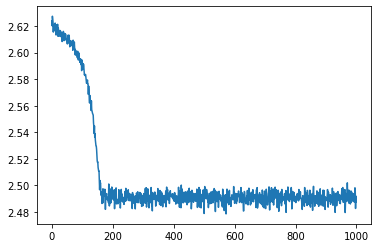

In [9]:
plt.plot(step_1Dt,losses_1Dt)
plt.savefig('Loss_ED_1Dtruncated.png')

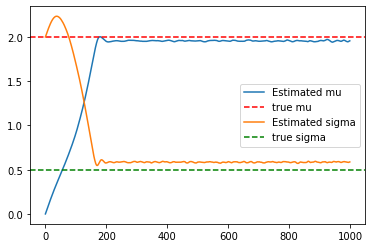

In [10]:
plt.plot(mus_ED_1Dt, label='Estimated mu')
plt.axhline(y=true_mu, color='r', linestyle='--', label='true mu')
plt.plot(sigmas_ED_1Dt, label='Estimated sigma')
plt.axhline(y=true_sigma, color='g', linestyle='--', label='true sigma')
plt.legend()
plt.savefig('parameters_ED_1Dtruncated.png')

In [11]:
# observed data array
observed_data_array = observed_data.detach().numpy()

In [18]:
# 1 step CD on truncated Gaussian
eta=0.01

#keep the initial parameters equal
mu0=0
sigma0=2
proposal_std=1
num_samples= len(observed_data_array)
iterations = 1000

mui_truncated,sigmai_truncated,ni,time_1_step_truncated, l2_1_step_truncated \
    = CD_1step(proposal_std, observed_data_array, iterations, mu0, sigma0, eta)

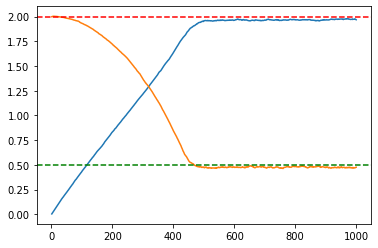

In [19]:
plt.plot(ni,mui_truncated, label='mean')
plt.plot(ni,sigmai_truncated, label='Sd')
plt.axhline(y=true_mu, color='r', linestyle='dashed', label='true mean')
plt.axhline(y=true_sigma, color='g', linestyle='dashed', label='true Sd')

In [20]:
# persistent CD on truncated Gaussian
mui_truncated_per,sigmai_truncated_per,ni,time_persistent_truncated, l2_persistent_truncated \
    = CD_persistent(proposal_std, observed_data_array, iterations, mu0,sigma0,eta)

In [21]:
# 3 step CD on truncated Gaussian
mui_truncated_3step,sigmai_truncated_3step,ni,time_3_step_truncated, l2_3_step_truncated \
      = CD_3step(proposal_std, observed_data_array, iterations, mu0,sigma0,eta)

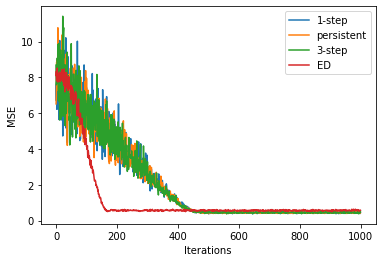

In [22]:
# comparison on L2 loss
plt.plot(l2_1_step_truncated, label='1-step')
plt.plot(l2_persistent_truncated, label='persistent')
plt.plot(l2_3_step_truncated, label='3-step')
plt.plot(l2_1Dtruncated_ED, label='ED')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('L2_loss_1Dtruncated_compare.png')

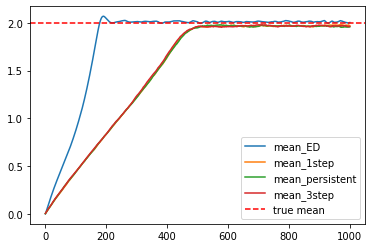

In [23]:
plt.plot(ni,mus_ED, label='mean_ED')
plt.plot(ni,mui_truncated, label='mean_1step')
plt.plot(ni,mui_truncated_per, label='mean_persistent')
plt.plot(ni,mui_truncated_3step, label='mean_3step')
plt.axhline(y=true_mu, color='r', linestyle='dashed', label='true mean')
plt.legend()
plt.savefig('mean_convergence_1Dtruncated_compare.png')

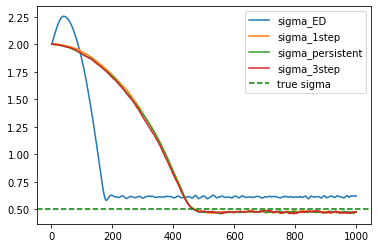

In [24]:
plt.plot(ni,sigmas_ED, label='sigma_ED')
plt.plot(ni,sigmai_truncated, label='sigma_1step')
plt.plot(ni,sigmai_truncated_per, label='sigma_persistent')
plt.plot(ni,sigmai_truncated_3step, label='sigma_3step')
plt.axhline(y=true_sigma, color='g', linestyle='dashed', label='true sigma')
plt.legend()
plt.savefig('sigma_convergence_1Dtruncated_compare.png')

In [28]:
# Final MSE and computational time

print(f"1 step CD MSE for truncated Gaussian: {l2_1_step_truncated[-1]}")
print(f"1 step CD Computing time for truncated Gaussian: {time_1_step_truncated}")

print(f"persistent CD MSE for truncated Gaussian: {l2_persistent_truncated[-1]}")
print(f"persistent CD Computing time for truncated Gaussian: {time_persistent_truncated}")

print(f"3 step CD MSE for truncated Gaussian: {l2_3_step_truncated[-1]}")
print(f"3 step CD Computing time for truncated Gaussian: {time_3_step_truncated}")

print(f"MSE for ED on truncated Gaussian: {l2_1Dtruncated_ED[-1]}")
print(f"Computing time for ED on truncated Gaussian: {computing_time_1Dtruncated_ED}")

1 step CD MSE for truncated Gaussian: 0.45471567343748365
1 step CD Computing time for truncated Gaussian: 96.3732271194458
persistent CD MSE for truncated Gaussian: 0.44240120538334166
persistent CD Computing time for truncated Gaussian: 107.28483200073242
3 step CD MSE for truncated Gaussian: 0.5211247824450791
3 step CD Computing time for truncated Gaussian: 157.9869213104248
MSE for ED on truncated Gaussian: 0.5804237127304077
Computing time for ED on truncated Gaussian: 1.842130184173584


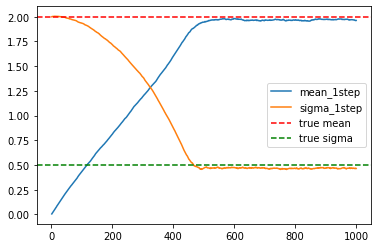

In [432]:
plt.plot(ni,mui_truncated, label='mean_1step')
plt.plot(ni,sigmai_truncated, label='sigma_1step')
plt.axhline(y=true_mu, color='r', linestyle='dashed', label='true mean')
plt.axhline(y=true_sigma, color='g', linestyle='dashed', label='true sigma')
plt.legend()
plt.savefig('1_step_CD_truncated_1D_compare.png')

# 1D and 1D truncated

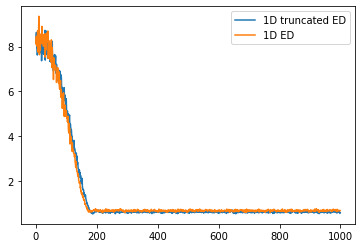

In [345]:
plt.plot(l2_1Dtruncated_ED, label='1D truncated ED')
plt.plot(l2_log, label='1D ED')
plt.legend()
plt.savefig('L2_loss_1Dtruncated_ED_compare.png')

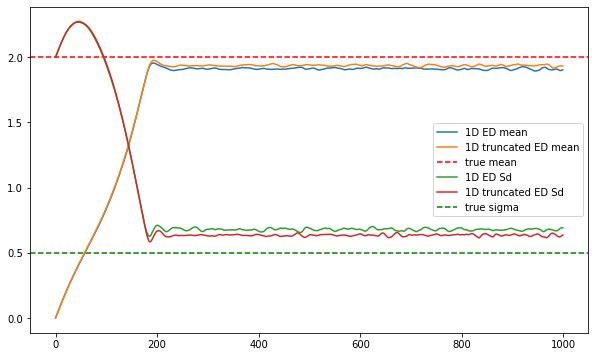

In [349]:
plt.figure(figsize=(10, 6))
plt.plot(mus_ED, label='1D ED mean')
plt.plot(mus_ED_1Dt, label='1D truncated ED mean')
plt.axhline(y=true_mu, color='r', linestyle='dashed', label='true mean')
plt.plot(sigmas_ED, label='1D ED Sd')
plt.plot(sigmas_ED_1Dt, label='1D truncated ED Sd')
plt.axhline(y=true_sigma, color='g', linestyle='dashed', label='true sigma')
plt.legend()
plt.savefig('parameters_ED_1Dtruncated_compare.png')

# 2D

In [2]:
# define the model for the Multivariate Gaussian distribution
class MultivariateGaussian(nn.Module):
    def __init__(self, mean: float, cov: float):
        super(MultivariateGaussian, self).__init__()
        self.mean = nn.Parameter(torch.tensor([mean]).squeeze(), requires_grad=True)
        self.cov = nn.Parameter(torch.tensor([cov]).squeeze(), requires_grad=True)
        self.dim = self.mean.shape[-1]

    def forward(self, x):
        cov_matrix = self.cov.view(self.dim, self.dim)
        cov_matrix = cov_matrix @ cov_matrix.T + torch.eye(self.dim) * 1e-6
        self.inv_cov = torch.inverse(cov_matrix)
        self.det_cov = torch.det(cov_matrix)
        self.norm_const = 1.0 / torch.sqrt((2 * np.pi) ** self.dim * self.det_cov)
        x = x.float()
        diff = x - self.mean
        exponent = -0.5 * torch.sum(diff @ self.inv_cov * diff, dim=1)
        return - torch.log(self.norm_const * torch.exp(exponent))

    def sample(self, num_samples: int):
        # ensure the covariance matrix is positive definite
        cov = self.cov
        cov = cov @ cov.T
        samples = self.mean + torch.randn(num_samples, self.dim) @ torch.linalg.cholesky(cov)
        return samples

In [3]:
# train the loop
def train(model, data, epochs=1000, learning_rate=0.1):
    loss1 = []
    mu1 = []
    mu2 = []
    sigma1 = []
    step = []
    
    time1 = time.time()
    l2 = []

    # gradient descent
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, w=w_stable)
        
        mu_1 = model.mean[0].item()
        cov_1 = model.cov[0][0].item()

        loss1.append(loss.item())
        mu1.append(mu_1)
        mu2.append(model.mean[1].item())
        sigma1.append(cov_1)

        sample_train = model.sample(data.size(0)).detach().numpy()
        MSE = ((sample_train - data.detach().numpy()) ** 2).mean()
        l2.append(MSE)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, mu1 = {mu_1}, sigma1 = {cov_1}")
        step.append(epoch)

    time2 = time.time()

    return loss1, mu1, mu2, sigma1, step, time2-time1, l2

In [4]:
# define loss function converge to the energy discrepancy 
def ED(E_theta, samples, M = 4, t =1, w=1):
    device = samples.device

    si_i = np.sqrt(t) * torch.randn_like(samples).to(device)
    si_ij = np.sqrt(t) * torch.randn(samples.size(0), M, *samples.shape[1:]).to(device)

    sum_part = samples.unsqueeze(1) + si_i.unsqueeze(1) + si_ij
    
    # compute the part of loss part
    E_1 = E_theta(samples).view(samples.size(0), -1)
    E_2 = E_theta(sum_part.view(-1, *samples.shape[1:])).view(samples.size(0), -1)

    # compute the loss in the sum part
    loss_i = E_1 - E_2
    
    if w != 0:
        loss_i = torch.cat([loss_i, np.log(w) * torch.ones_like(loss_i[:, :1])], dim=-1)
    
    # take the logsumexp step to compute the loss
    loss = loss_i.logsumexp(dim=-1).mean()
    return loss

In [5]:
# define the target model for the multivariate Gaussian distribution
true_mu2D = [0.0, 0.0]
true_sigma2D = [[1.0, 0.0], [0.0, 1.0]]
observed_data2D = MultivariateGaussian(mean=true_mu2D, cov=true_sigma2D).sample(1000).detach().numpy()
observed_data_tensor2D = torch.tensor(observed_data2D, dtype=torch.float32)

In [6]:
# define the target model for the multivariate Gaussian distribution
true_mu2D = torch.tensor([0.0, 0.0])
true_sigma2D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
observed_data2D = torch.distributions.MultivariateNormal(true_mu2D, true_sigma2D).sample((1000,))
observed_data_tensor2D = observed_data2D

# initilaize the model
mu_init2D = [-4.0, 3.0]
sigma_init2D = [[3.0, 0.0], [0.0, 3.0]]

w_stable = 10.0
model2D = MultivariateGaussian(mu_init2D, sigma_init2D)

In [7]:
# train the model
losses_2D, mus1_2D, mus2_2D, sigmas_2D, step_2D, computing_time_2D, l2_2D = train(model2D, observed_data_tensor2D)

Epoch 0: Loss = 2.651370048522949, mu1 = -4.0, sigma1 = 3.0
Epoch 100: Loss = 2.5344347953796387, mu1 = 0.032270967960357666, sigma1 = 1.5233211517333984
Epoch 200: Loss = 2.526857852935791, mu1 = 0.0019665025174617767, sigma1 = 1.2522153854370117
Epoch 300: Loss = 2.527129888534546, mu1 = 0.004568932577967644, sigma1 = 1.2781648635864258
Epoch 400: Loss = 2.5275278091430664, mu1 = 0.0012033842504024506, sigma1 = 1.2080963850021362
Epoch 500: Loss = 2.524076461791992, mu1 = 0.023557430133223534, sigma1 = 1.1884280443191528
Epoch 600: Loss = 2.522249221801758, mu1 = 0.05948089808225632, sigma1 = 1.2247387170791626
Epoch 700: Loss = 2.5271778106689453, mu1 = 0.08581284433603287, sigma1 = 1.2791775465011597
Epoch 800: Loss = 2.5219554901123047, mu1 = -0.0272497721016407, sigma1 = 1.241322636604309
Epoch 900: Loss = 2.5260891914367676, mu1 = 0.07975206524133682, sigma1 = 1.2544832229614258


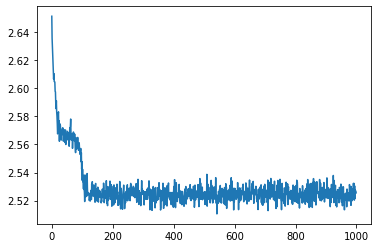

In [9]:
plt.plot(step_2D,losses_2D)
plt.savefig('Loss_ED_2D.png')

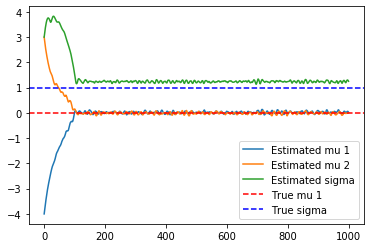

In [11]:
plt.plot(step_2D,mus1_2D, label='Estimated mu 1')
plt.plot(step_2D,mus2_2D, label='Estimated mu 2')
plt.plot(step_2D,sigmas_2D, label='Estimated sigma')
plt.axhline(y=true_mu2D[0], color='r', linestyle='--', label='True mu 1')
plt.axhline(y=true_sigma2D[0][0], color='b', linestyle='--', label='True sigma')
plt.legend()
plt.savefig('parameters_ED_2D.png')

# compare with CD on 2D

In [390]:
def log_likelihood(x, mean, covariance_matrix):
    dim = len(mean)
    det_covariance = np.linalg.det(covariance_matrix)
    inv_covariance = np.linalg.inv(covariance_matrix)
    return - 0.5 * dim * np.log(2*np.pi) - 0.5 * np.log(det_covariance) - 0.5 * (x - mean).T @ inv_covariance @ (x - mean)

# log accpetance rate
def log_acceptance_probability(candidate_x, current_x, mean, covariance):
    return log_likelihood(candidate_x, mean, covariance) - log_likelihood(current_x, mean, covariance)

# proposal distributionn
def proposal_distribution(current_x, proposal_std, cov): 
        re = current_x + proposal_std * np.random.multivariate_normal(np.zeros(len(current_x)), cov)
        return re

def partial_mean(x, mean, cov):
    inv_covariance = np.linalg.inv(cov)
    return  inv_covariance @ (x - mean)

def partial_cov(x, mean, cov):
    inv = np.linalg.inv(cov)
    diff = x - mean
    return -0.5 * (inv - inv @ np.outer(diff, diff) @ inv)

def MH(num , train_data, pro_std, mean, cov):
    # initialize
    current_x = train_data 
    samples_x = []

    for _ in range(num):
        
        # produce candidate by proposal distribution
        candidate_x = proposal_distribution(current_x, pro_std,  cov)
        a_r = log_acceptance_probability(candidate_x, current_x, mean, cov)
        
        if np.log(np.random.uniform(0,1)) < a_r:
            current_x = candidate_x
        
        samples_x.append(current_x)
    
    return samples_x

In [391]:
def MH_1step2D(stepsize, mean_1step, covariance_1tep, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    time_1 = time.time()
    l2 = []

    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        X = MH(num_sample, initial_state, pro, mean_1step, covariance_1tep)
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean_1step, covariance_1tep)
            sum1_sigma += partial_cov(sample[j], mean_1step, covariance_1tep)

            sum_dash_mu += partial_mean(X[j], mean_1step, covariance_1tep)
            sum_dash_sigma += partial_cov(X[j], mean_1step, covariance_1tep)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance_1tep + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean_1step + stepsize * (expected1_mu-expected_dash_mu)

        MSE = ((X - sample) ** 2).mean()
        l2.append(MSE)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean_1step = mean_i
        covariance_1tep = covariance_matrix_i
        
    time_2 = time.time()
    time_cost = time_2 - time_1


    return ni, mui, mui1, sigmai, sigmai1,time_cost, l2

In [392]:
def MH_persistant2D(stepsize, mean, covariance, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    time_1 = time.time()
    l2 = []

    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])

        # persistent step
        X = MH(num_sample, initial_state, pro, mean, covariance)
        initial_state = X[-1]

        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean, covariance)
            sum1_sigma += partial_cov(sample[j], mean, covariance)

            sum_dash_mu += partial_mean(X[j], mean, covariance)
            sum_dash_sigma += partial_cov(X[j], mean, covariance)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean + stepsize * (expected1_mu-expected_dash_mu)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean = mean_i
        covariance = covariance_matrix_i

        MSE = ((X - sample) ** 2).mean()
        l2.append(MSE)
        
    time_2 = time.time()
    time_cost = time_2 - time_1
    return ni, mui, mui1, sigmai, sigmai1,time_cost, l2

In [393]:
def MH_3step2D(stepsize, mean, covariance, pro, sample , iterations):
    ni=[]
    mui=[]
    mui1 = []
    sigmai=[]
    sigmai1 = []
    initial_state = sample[0]
    num_sample = len(sample)
    
    time_1 = time.time()
    l2 = []

    for i in range(iterations):
        # intialize
        sum1_mu = np.array([0.0, 0.0])
        sum_dash_mu = np.array([0.0, 0.0])
        sum1_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        sum_dash_sigma = np.array([[0.0, 0.0],[0.0, 0.0]])
        
        # 3-step MH 
        X1 = MH(num_sample, initial_state, pro, mean, covariance)
        X2 = MH(num_sample, X1[-1], pro, mean, covariance)
        X = MH(num_sample, X2[-1], pro, mean, covariance)
        
        #calculate the sum of gradient
        for j in range(num_sample):
            
            #gradient of log(p(x))
            sum1_mu += partial_mean(sample[j], mean, covariance)
            sum1_sigma += partial_cov(sample[j], mean, covariance)

            sum_dash_mu += partial_mean(X[j], mean, covariance)
            sum_dash_sigma += partial_cov(X[j], mean, covariance)

        expected1_mu = sum1_mu/num_sample
        expected_dash_mu = sum_dash_mu/num_sample
        expected1_sigma = sum1_sigma/num_sample
        expected_dash_sigma = sum_dash_sigma/num_sample

        covariance_matrix_i = covariance + stepsize * (expected1_sigma - expected_dash_sigma)
        mean_i = mean + stepsize * (expected1_mu-expected_dash_mu)

        #plot data
        n = i + 1
        ni.append(n)
        mui.append(mean_i[0])
        mui1.append(mean_i[1])
        sigmai.append(covariance_matrix_i[0][0])
        sigmai1.append(covariance_matrix_i[1][1])
        mean = mean_i
        covariance = covariance_matrix_i

        MSE = ((X - sample) ** 2).mean()
        l2.append(MSE)
        
    time_2 = time.time()
    time_cost = time_2 - time_1
    return ni, mui, mui1, sigmai, sigmai1,time_cost, l2

In [394]:
# set the parameters
stepsize = 0.1
pro = 1
iterations = 1000

In [395]:
# 1-step CD
A = MH_1step2D(stepsize, mu_init2D, sigma_init2D, pro, observed_data2D , iterations)

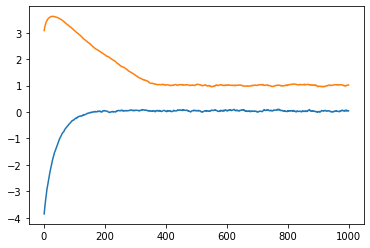

In [396]:
mu_1_2D = A[1]
sigma_1_2D = A[3]
plt.plot(A[0],mu_1_2D, label='mean 1_step CD')
plt.plot(A[0],sigma_1_2D, label='Sd 1_step CD')

In [397]:
# persistent CD
B = MH_persistant2D(stepsize, mu_init2D, sigma_init2D, pro, observed_data2D , iterations)

In [398]:
# 3-step CD
C = MH_3step2D(stepsize, mu_init2D, sigma_init2D, pro, observed_data2D , iterations)

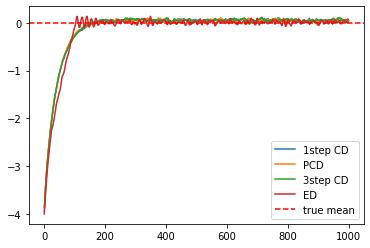

In [503]:
# compare the mean convergence
plt.plot(A[0],mu_1_2D, label='1step CD')
plt.plot(B[0],B[1], label='PCD')
plt.plot(C[0],C[1], label='3step CD')
plt.plot(step_2D, mus1_2D, label='ED')
plt.axhline(y=true_mu2D[0], color='r', linestyle='dashed', label='true mean')
plt.legend()
plt.savefig('mean_convergence_2D_compare.png')

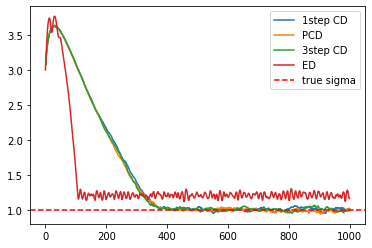

In [504]:
# compare the sigma convergence
plt.plot(A[0],sigma_1_2D, label='1step CD')
plt.plot(B[0],B[3], label='PCD')
plt.plot(C[0],C[3], label='3step CD')
plt.plot(step_2D, sigmas_2D, label='ED')
plt.axhline(y=true_sigma2D[0][0], color='r', linestyle='dashed', label='true sigma')
plt.legend()
plt.savefig('sigma_convergence_2D_compare.png')

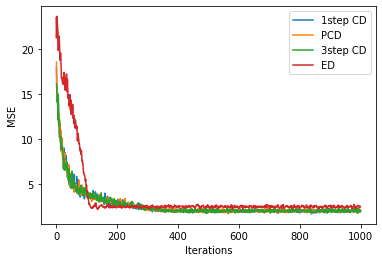

In [494]:
# compare the l2 loss
plt.plot(A[0],A[-1], label='1step CD')
plt.plot(B[0],B[-1], label='PCD')
plt.plot(C[0],C[-1], label='3step CD')
plt.plot(step_2D, l2_2D, label='ED')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.savefig('L2_loss_2D_compare.png')

In [402]:
print(f"Computing time for 2D Gaussian: {computing_time_2D}")
print(f"Computing time for 1-step CD: {A[-2]}")
print(f"Computing time for persistent CD: {B[-2]}")
print(f"Computing time for 3-step CD: {C[-2]}")

print(f"MSE for 2D Gaussian: {l2_2D[-1]}")
print(f"MSE for 1-step CD: {A[-1][-1]}")
print(f"MSE for persistent CD: {B[-1][-1]}")
print(f"MSE for 3-step CD: {C[-1][-1]}")

Computing time for 2D Gaussian: 3.1153128147125244
Computing time for 1-step CD: 230.97865176200867
Computing time for persistent CD: 240.11890411376953
Computing time for 3-step CD: 591.5898358821869
MSE for 2D Gaussian: 2.69136381149292
MSE for 1-step CD: 2.088505250226337
MSE for persistent CD: 2.0934579576645356
MSE for 3-step CD: 1.9758825292952344


# truncated Multivariate Gaussian

In [15]:
# define the observed data
true_mu2D_t = torch.tensor([0.0, 0.0])
true_sigma2D_t = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
observed_data2D_t = torch.distributions.MultivariateNormal(true_mu2D_t, true_sigma2D_t).sample((10000,))

In [16]:
# truncated
lower_bound = [-2.0, 0.0]
upper_bound = [0.0, 2.0]
observed_data2D_t = observed_data2D_t[observed_data2D_t[:,0] >= lower_bound[0]]
observed_data2D_t = observed_data2D_t[observed_data2D_t[:,1] >= lower_bound[1]]
observed_data2D_t = observed_data2D_t[observed_data2D_t[:,0] <= upper_bound[0]]
observed_data2D_t = observed_data2D_t[observed_data2D_t[:,1] <= upper_bound[1]]
observed_data2D_t = observed_data2D_t[:1000]
observed_data2D_tensor_t = observed_data2D_t

In [17]:
# initilaize the model
mu_init2D_t = [-4.0, 3.0]
sigma_init2D_t = [[3.0, 0.0], [0.0, 3.0]]

w_stable = 10.0
model2D_t = MultivariateGaussian(mu_init2D_t, sigma_init2D_t)

# train the model
losses_t, mus1_t, mus2_t, sigmas_t, step_t, computing_time_2D_t, l2_2D_t = train(model2D_t, observed_data2D_tensor_t)

Epoch 0: Loss = 2.6259167194366455, mu1 = -4.0, sigma1 = 3.0
Epoch 100: Loss = 2.4885306358337402, mu1 = -1.7537174224853516, sigma1 = 2.1401116847991943
Epoch 200: Loss = 2.4130239486694336, mu1 = -0.7925365567207336, sigma1 = 0.6111640334129333
Epoch 300: Loss = 2.4117319583892822, mu1 = -0.8131948113441467, sigma1 = 0.6032949090003967
Epoch 400: Loss = 2.4172065258026123, mu1 = -0.8366158604621887, sigma1 = 0.609500527381897
Epoch 500: Loss = 2.420295476913452, mu1 = -0.7922197580337524, sigma1 = 0.6219688057899475
Epoch 600: Loss = 2.4184165000915527, mu1 = -0.8067453503608704, sigma1 = 0.6576023697853088
Epoch 700: Loss = 2.4216153621673584, mu1 = -0.8246974349021912, sigma1 = 0.6478585004806519
Epoch 800: Loss = 2.4111547470092773, mu1 = -0.8145281076431274, sigma1 = 0.6113492846488953
Epoch 900: Loss = 2.4162380695343018, mu1 = -0.797868013381958, sigma1 = 0.6389610171318054


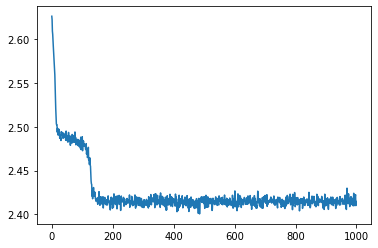

In [18]:
plt.plot(step_t,losses_t)
plt.savefig('Loss_ED_2D_truncated.png')

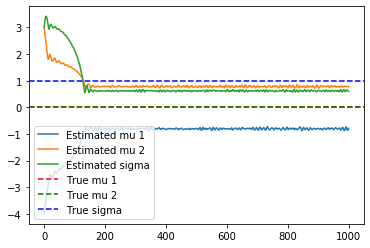

In [19]:
plt.plot(step_t,mus1_t, label='Estimated mu 1')
plt.plot(step_t,mus2_t, label='Estimated mu 2')
plt.plot(step_t,sigmas_t, label='Estimated sigma')
plt.axhline(y=true_mu2D[0], color='r', linestyle='--', label='True mu 1')
plt.axhline(y=true_mu2D[1], color='g', linestyle='--', label='True mu 2')
plt.axhline(y=true_sigma2D[0][0], color='b', linestyle='--', label='True sigma')
plt.legend()
plt.savefig('parameters_ED_2D_truncated.png')

In [460]:
# set the parameters
stepsize = 0.1
pro = 1
iterations = 1000
observed_data2D_t = observed_data2D_t.detach().numpy()

In [461]:
# 1-step CD
A_t = MH_1step2D(stepsize, mu_init2D_t, sigma_init2D_t, pro, observed_data2D_t , iterations)

In [462]:
# persistent CD
B_t = MH_persistant2D(stepsize, mu_init2D_t, sigma_init2D_t, pro, observed_data2D_t , iterations)

In [463]:
# 3-step CD
C_t = MH_3step2D(stepsize, mu_init2D_t, sigma_init2D_t, pro, observed_data2D_t , iterations)

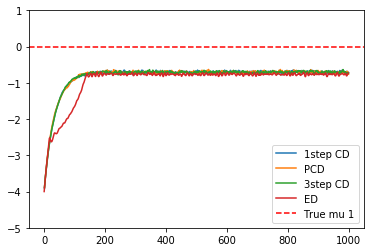

In [464]:
# compare the mean convergence

plt.plot(A_t[0],A_t[1], label='1step CD')
plt.plot(B_t[0],B_t[1], label='PCD')
plt.plot(C_t[0],C_t[1], label='3step CD')
plt.plot(step_t, mus1_t, label='ED')
plt.ylim(-5,1)
plt.axhline(y=true_mu2D[0], color='r', linestyle='--', label='True mu 1')
plt.legend()
plt.savefig('mean_convergence_2D_truncated_compare.png')

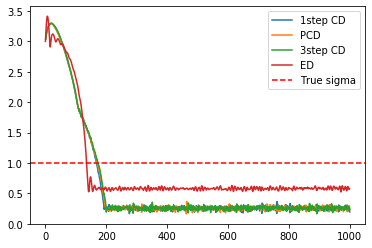

In [466]:
# compare the sigma convergence
plt.plot(A_t[0],A_t[3], label='1step CD')
plt.plot(B_t[0],B_t[3], label='PCD')
plt.plot(C_t[0],C_t[3], label='3step CD')
plt.plot(step_t, sigmas_t, label='ED')
plt.axhline(y=true_sigma2D[0][0], color='r', linestyle='--', label='True sigma')
plt.legend()
plt.savefig('sigma_convergence_2D_truncated_compare.png')

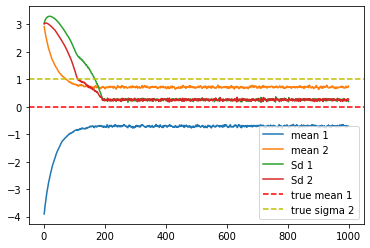

In [469]:
plt.plot(A_t[0],A_t[1], label='mean 1')
plt.plot(A_t[0],A_t[2], label='mean 2')
plt.plot(A_t[0],A_t[3], label='Sd 1')
plt.plot(A_t[0],A_t[4], label='Sd 2')
plt.axhline(y=true_mu2D[0], color='r', linestyle='dashed', label='true mean 1')
plt.axhline(y=true_sigma2D[1][1], color='y', linestyle='dashed', label='true sigma 2')
plt.legend()

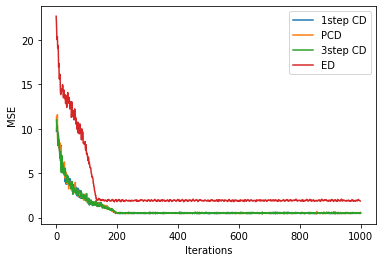

In [500]:
# compare the l2 loss
plt.plot(A_t[0],A_t[-1], label='1step CD')
plt.plot(B_t[0],B_t[-1], label='PCD')
plt.plot(C_t[0],C_t[-1], label='3step CD')
plt.plot(step_t, l2_2D_t, label='ED')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.savefig('L2_loss_2D_truncated_compare.png')

In [452]:
print(f"Computing time for ED on truncated 2D Gaussian: {computing_time_2D_t}")
print(f"Computing time for 1-step CD on truncated: {A_t[-2]}")
print(f"Computing time for persistent CD on truncated: {B_t[-2]}")
print(f"Computing time for 3-step CD on truncated: {C_t[-2]}")

print(f"MSE for ED on truncated 2D Gaussian: {l2_2D_t[-1]}")
print(f"MSE for 1-step CD on truncated: {A_t[-1][-1]}")
print(f"MSE for persistent CD on truncated: {B_t[-1][-1]}")
print(f"MSE for 3-step CD on truncated: {C_t[-1][-1]}")

Computing time for ED on truncated 2D Gaussian: 3.4448740482330322
Computing time for 1-step CD on truncated: 237.49090695381165
Computing time for persistent CD on truncated: 251.946937084198
Computing time for 3-step CD on truncated: 590.2105238437653
MSE for ED on truncated 2D Gaussian: 0.6286835670471191
MSE for 1-step CD on truncated: 0.549768109815732
MSE for persistent CD on truncated: 0.5002509724818823
MSE for 3-step CD on truncated: 0.4768525333714505


# 2D and 2D truncated

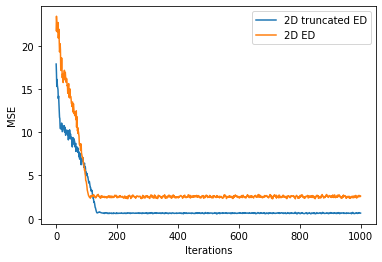

In [20]:
plt.plot(l2_2D_t, label='2D truncated ED')
plt.plot(l2_2D, label='2D ED')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.savefig('L2_loss_2Dtruncated_ED_compare.png')

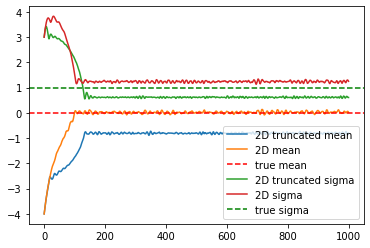

In [21]:
plt.plot(mus1_t, label='2D truncated mean')
plt.plot(mus1_2D, label='2D mean')
plt.axhline(y=true_mu2D[0], color='r', linestyle='dashed', label='true mean')
plt.plot(sigmas_t, label='2D truncated sigma')
plt.plot(sigmas_2D, label='2D sigma')
plt.axhline(y=true_sigma2D[0][0], color='g', linestyle='dashed', label='true sigma')
plt.legend()
plt.savefig('parameters_ED_2Dtruncated_compare.png')